<a href="https://colab.research.google.com/github/Gaurav-Yaduvanshi/Face-Emotion-Recognition/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name** - Face Emotion Recognition

# **Project Introduction**

The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms. Digital classrooms are conducted via video telephony software program (ex-Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance.
While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analyzed using deep learning algorithms.

Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analyzed and tracked.

I will solve the above-mentioned challenge by applying deep learning algorithms to live video data. The solution to this problem is by recognizing facial emotions.

# **Attribute Information**
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.


# **Let's Begin**

# Importing Libraries

In [3]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2
import os

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Removing Warnings

import warnings                                                                                
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Dataset Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Dataset loading
df1 = pd.read_csv('/content/drive/MyDrive/Almabetter/Face_Emotion_Recognition/fer2013.csv')

In [5]:
image_size = 48
folder_path = '/content/drive/MyDrive/Almabetter/Face_Emotion_Recognition/face_emotion/'

## Dataset Information

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


## Dataset Rows & Columns 

In [ ]:
# Shape of the dataset
df1.shape

(35887, 3)

In [ ]:
# Dataset First Look
df1.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Missing Values

In [ ]:
# Missing Values/Null Values Count
miss_values = df1.isna().sum()
miss_values

emotion    0
pixels     0
Usage      0
dtype: int64

In [ ]:
# Dataset Describe
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
emotion,35887.0,3.323265,1.873819,0.0,2.0,3.0,5.0,6.0


In [ ]:
# Dataset Describe (objects)
df1.describe(include='O').T

,count,unique,top,freq
pixels,35887,34034,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,12
Usage,35887,3,Training,28709


## Unique values

In [ ]:
# Write your code to make your dataset analysis ready.
df_desc = []
for column in df1.columns:
  df_desc.append([column,
                  df1[column].dtypes,
                  df1[column].isnull().sum(),
                  round(df1[column].isnull().sum()/len(df1)*100, 2),
                  df1[column].nunique(),
                  df1[column].unique()])

## storing all the information in a single table just to keep it neat 
column_desc = pd.DataFrame(df_desc, columns = ['Column', 'Dtype', 'Null', 'Null (%)', 'nUnique', 'Unique'])
column_desc

,Column,Dtype,Null,Null (%),nUnique,Unique
0,emotion,int64,0,0.0,7,"[0, 2, 4, 6, 3, 5, 1]"
1,pixels,object,0,0.0,34034,[70 80 82 72 58 58 60 63 54 58 60 48 89 115 12...
2,Usage,object,0,0.0,3,"[Training, PublicTest, PrivateTest]"


# Data Visualization

# Displaying Emotions

In [ ]:
#lable of different emotion
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

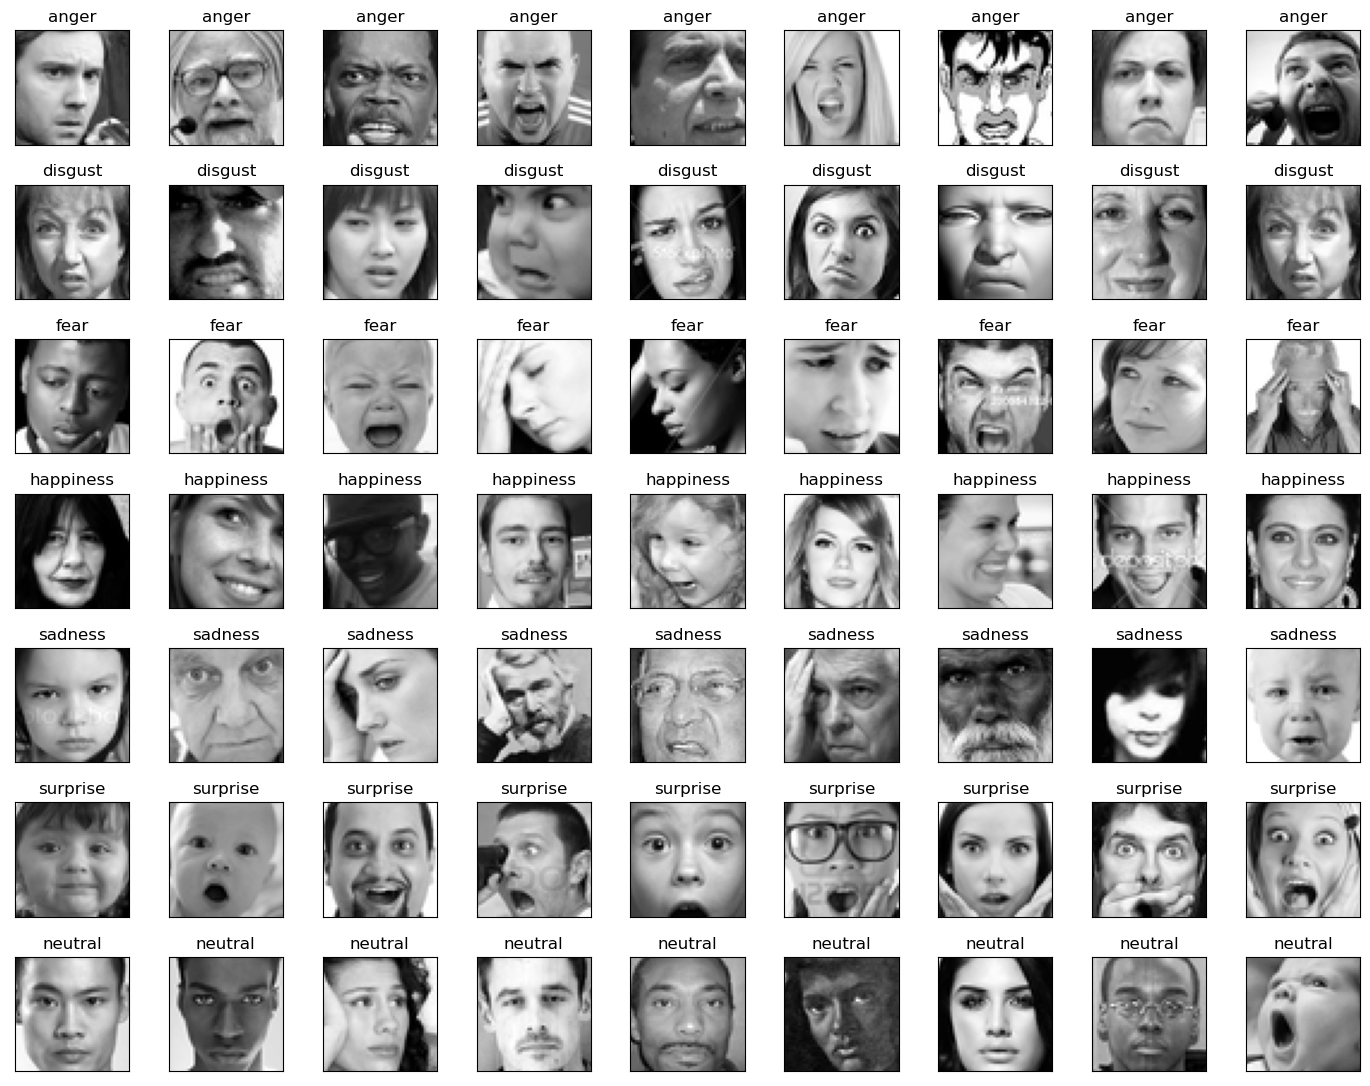

In [ ]:
# size of the image: 48*48 pixels

fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(9):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(9, 9, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

# Data Preprocessing

In [ ]:
# Initialize image data generator
batch_size  = 128

datagen_train  = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

# Preprocess all train images
train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (image_size,image_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

# Preprocess all test images
test_set = datagen_val.flow_from_directory(folder_path+"test",
                                              target_size = (image_size,image_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Model Structures

# CNN Model 

In [ ]:
classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(classes, activation='softmax'))



opt = Adam(lr = 0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

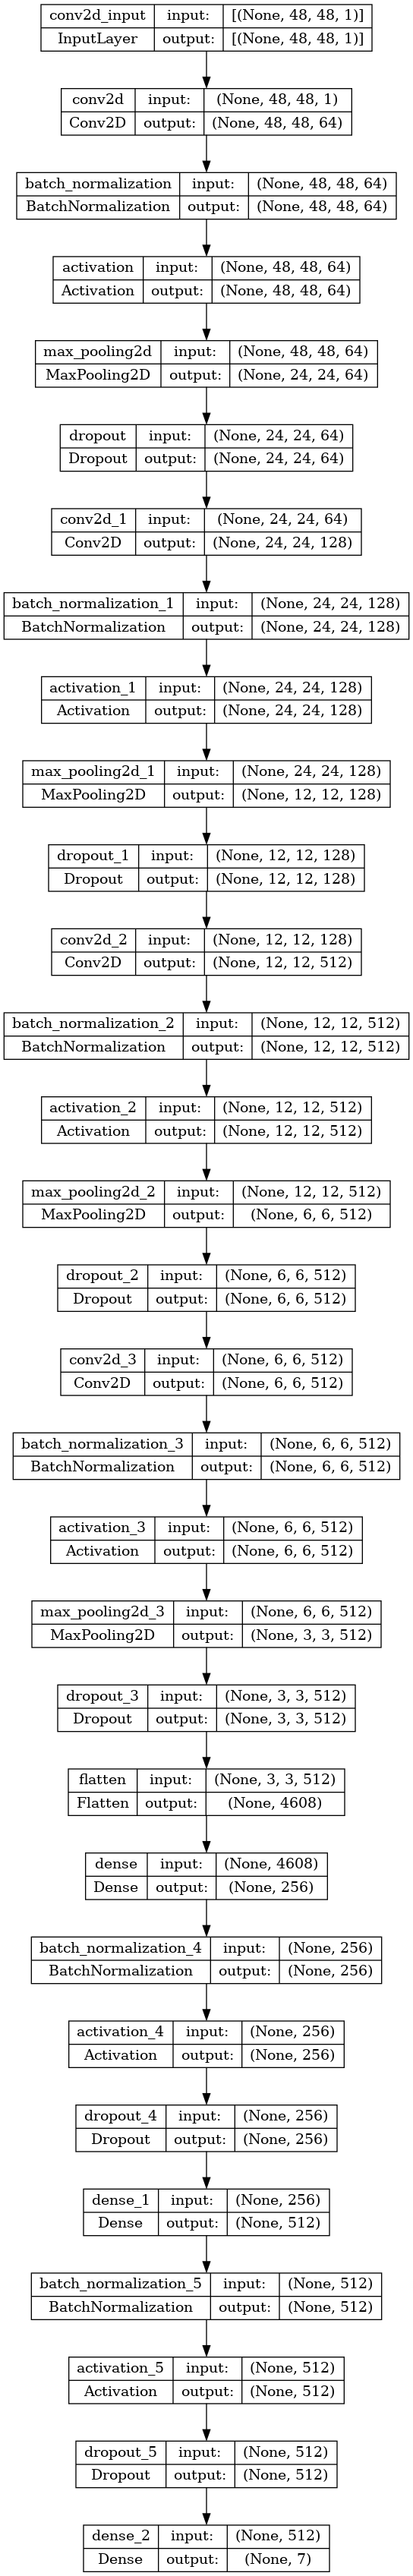

In [ ]:
#plot for architechture
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True)

## CNN Fitting Train and Test

In [ ]:
checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

## CNN Model Training

In [ ]:
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list)

Epoch 1/48
224/224 [==============================] - 32s 144ms/step - loss: 1.0966 - accuracy: 0.5814 - val_loss: 1.2430 - val_accuracy: 0.5476 - lr: 0.0010
Epoch 2/48
224/224 [==============================] - 30s 134ms/step - loss: 1.0480 - accuracy: 0.5997 - val_loss: 1.2902 - val_accuracy: 0.5264 - lr: 0.0010
Epoch 3/48
224/224 [==============================] - 30s 132ms/step - loss: 1.0020 - accuracy: 0.6216 - val_loss: 1.1358 - val_accuracy: 0.5732 - lr: 0.0010
Epoch 4/48
224/224 [==============================] - 31s 140ms/step - loss: 0.9641 - accuracy: 0.6363 - val_loss: 1.1336 - val_accuracy: 0.5571 - lr: 0.0010
Epoch 5/48
224/224 [==============================] - 31s 140ms/step - loss: 0.9186 - accuracy: 0.6573 - val_loss: 1.2061 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 6/48
224/224 [==============================] - 30s 136ms/step - loss: 0.8787 - accuracy: 0.6685 - val_loss: 1.1306 - val_accuracy: 0.5808 - lr: 0.0010
Epoch 7/48
224/224 [==============================] 

# Resnet
This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used 'ELU' as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. 'he_normal' kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results

## Resnet Model

In [ ]:
# create model structure
classes = 7

resnet_model = Sequential(name='DCNN')

#1st layer
resnet_model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
resnet_model.add(BatchNormalization())
resnet_model.add(Activation('elu'))
resnet_model.add(MaxPooling2D(pool_size = (2,2)))
resnet_model.add(Dropout(0.25))

#2nd layer
resnet_model.add(Conv2D(64,(5,5),padding = 'same'))
resnet_model.add(BatchNormalization())
resnet_model.add(Activation('elu'))
resnet_model.add(MaxPooling2D(pool_size = (2,2)))
resnet_model.add(Dropout (0.25))

#3rd layer
resnet_model.add(Conv2D(128,(3,3),padding = 'same'))
resnet_model.add(BatchNormalization())
resnet_model.add(Activation('elu'))
resnet_model.add(MaxPooling2D(pool_size = (2,2)))
resnet_model.add(Dropout (0.25))

#4th layer
resnet_model.add(Conv2D(256,(3,3), padding='same'))
resnet_model.add(BatchNormalization())
resnet_model.add(Activation('elu'))
resnet_model.add(MaxPooling2D(pool_size=(2, 2)))
resnet_model.add(Dropout(0.25))

resnet_model.add(Flatten())

#Fully connected 1st layer
resnet_model.add(Dense(128))
resnet_model.add(BatchNormalization())
resnet_model.add(Activation('relu'))
resnet_model.add(Dropout(0.25))


# Fully connected layer 2nd layer
resnet_model.add(Dense(256))
resnet_model.add(BatchNormalization())
resnet_model.add(Activation('elu'))
resnet_model.add(Dropout(0.25))

resnet_model.add(Dense(classes, activation='softmax'))

opt = Adam(lr = 0.001)
resnet_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        102464 

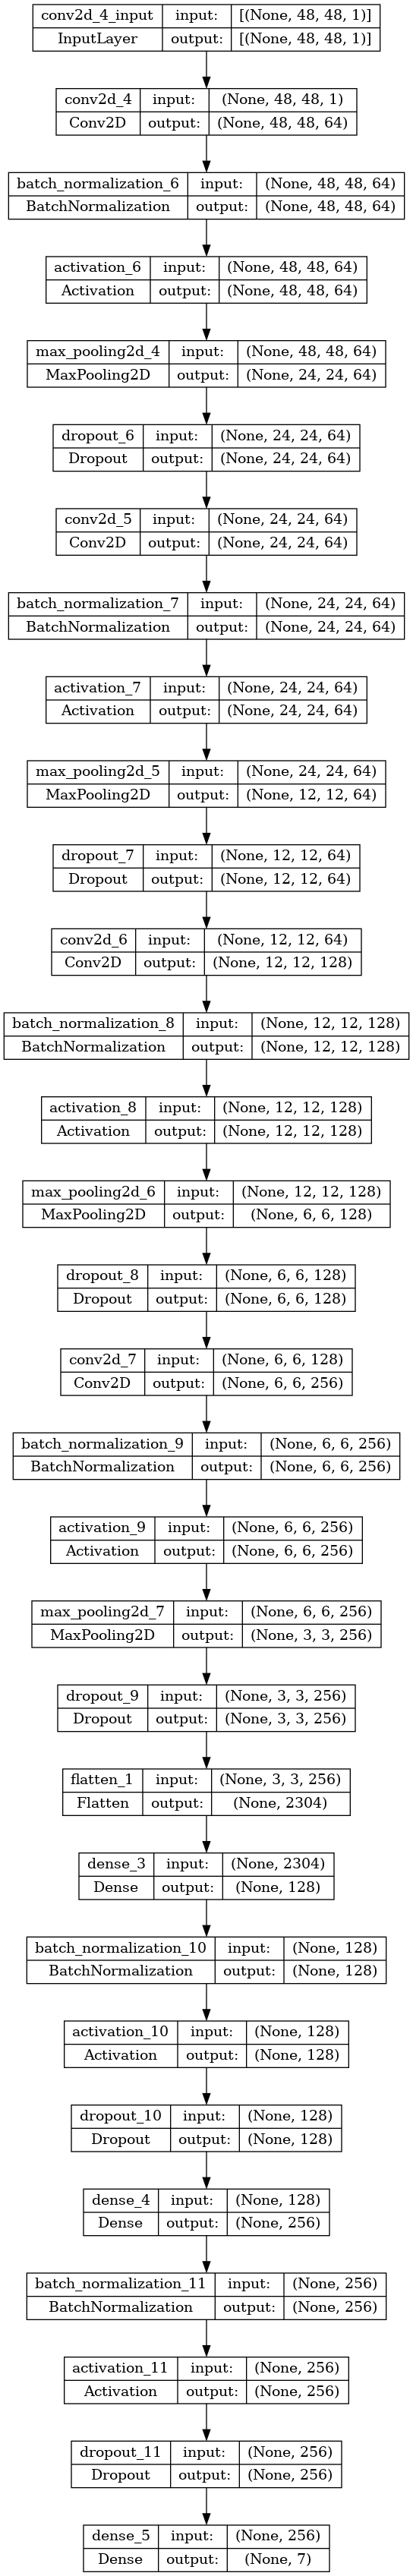

In [ ]:
#plot for architechture
from keras.utils.vis_utils import plot_model
plot_model(resnet_model, to_file='resnet_model.png',show_shapes=True, show_layer_names=True)

## Resnet Fitting Train and Test

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    restore_best_weights=True)

checkpoint = ModelCheckpoint('./Resnet.h5',monitor='val_acc', verbose=1, save_best_only=True, mode='max')

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,min_delta=0.001,
    verbose=1)

callbacks = [early_stopping,checkpoint,lr_scheduler]

epochs = 48
resnet_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy']) 

## Resnet Model Training

In [ ]:
#resnet model
resnet_history = resnet_model.fit_generator(train_set,
                                            steps_per_epoch= train_set.n//train_set.batch_size,
                                            epochs=epochs,
                                            validation_data= test_set,
                                            validation_steps = test_set.n//test_set.batch_size,
                                            callbacks=callbacks)

Epoch 1/48
224/224 [==============================] - 31s 137ms/step - loss: 1.4253 - accuracy: 0.4506 - val_loss: 1.3088 - val_accuracy: 0.4944 - lr: 0.0010
Epoch 2/48
224/224 [==============================] - 35s 155ms/step - loss: 1.3315 - accuracy: 0.4917 - val_loss: 1.3297 - val_accuracy: 0.4975 - lr: 0.0010
Epoch 3/48
224/224 [==============================] - 30s 135ms/step - loss: 1.2660 - accuracy: 0.5169 - val_loss: 1.3094 - val_accuracy: 0.5109 - lr: 0.0010
Epoch 4/48
224/224 [==============================] - 35s 154ms/step - loss: 1.2190 - accuracy: 0.5386 - val_loss: 1.2329 - val_accuracy: 0.5347 - lr: 0.0010
Epoch 5/48
224/224 [==============================] - 30s 134ms/step - loss: 1.1821 - accuracy: 0.5512 - val_loss: 1.1593 - val_accuracy: 0.5587 - lr: 0.0010
Epoch 6/48
224/224 [==============================] - 34s 151ms/step - loss: 1.1469 - accuracy: 0.5686 - val_loss: 1.1502 - val_accuracy: 0.5643 - lr: 0.0010
Epoch 7/48
224/224 [==============================] 

# Plotting Loss & Accuracy 

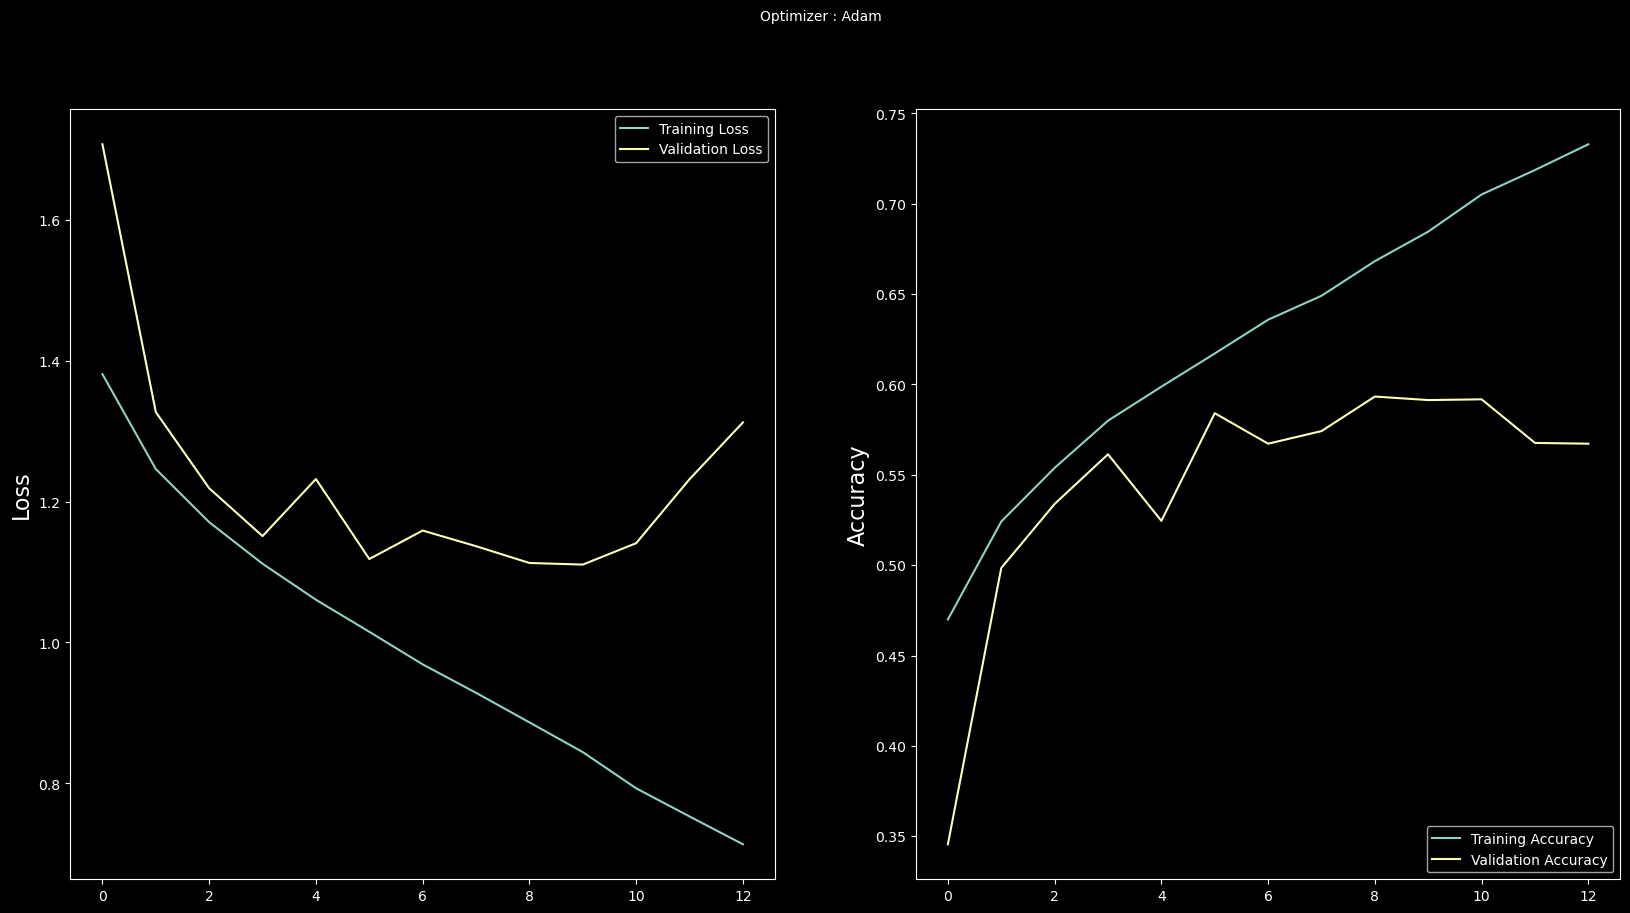

In [ ]:
# CNN loss and accuracy
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

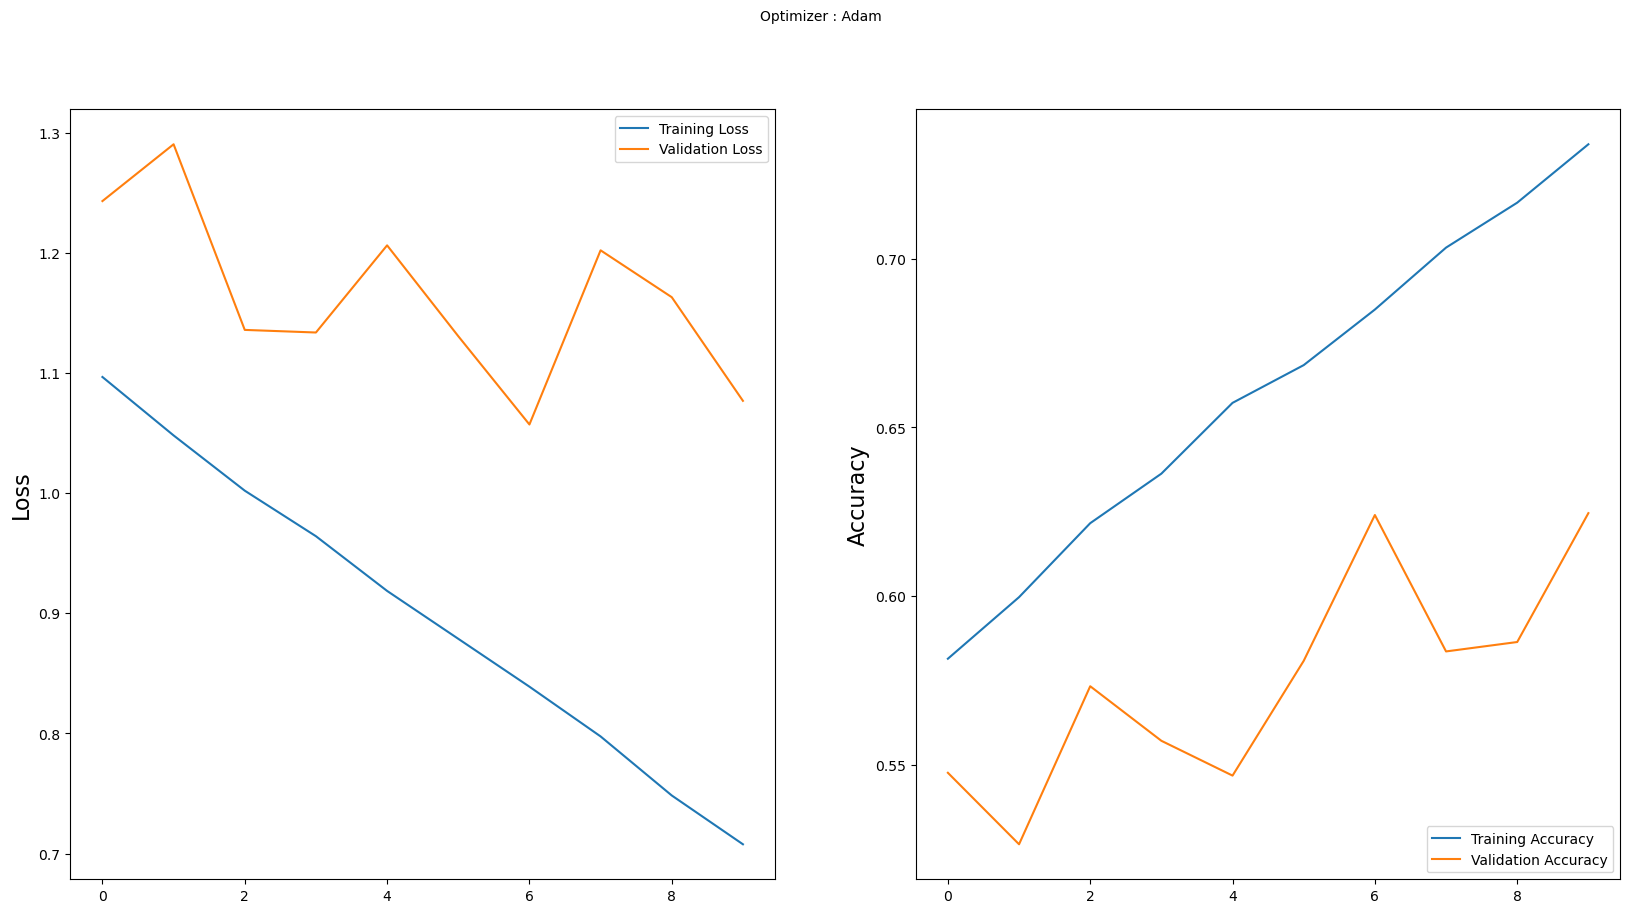

In [ ]:
# CNN plot
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_set.class_indices:
    target_names.append(key)
#Confution Matrix
Y_pred = model.predict_generator(test_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
# plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

       angry       0.67      0.39      0.49       958
     disgust       0.70      0.47      0.56       111
        fear       0.51      0.44      0.47      1024
       happy       0.81      0.83      0.82      1774
     neutral       0.48      0.72      0.58      1233
         sad       0.52      0.50      0.51      1247
    surprise       0.77      0.75      0.76       831

    accuracy                           0.62      7178
   macro avg       0.64      0.58      0.60      7178
weighted avg       0.64      0.62      0.62      7178



# Plotting Confusion Matrix

Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

       angry       0.67      0.39      0.49       958
     disgust       0.70      0.47      0.56       111
        fear       0.51      0.44      0.47      1024
       happy       0.81      0.83      0.82      1774
     neutral       0.48      0.72      0.58      1233
         sad       0.52      0.50      0.51      1247
    surprise       0.77      0.75      0.76       831

    accuracy                           0.62      7178
   macro avg       0.64      0.58      0.60      7178
weighted avg       0.64      0.62      0.62      7178



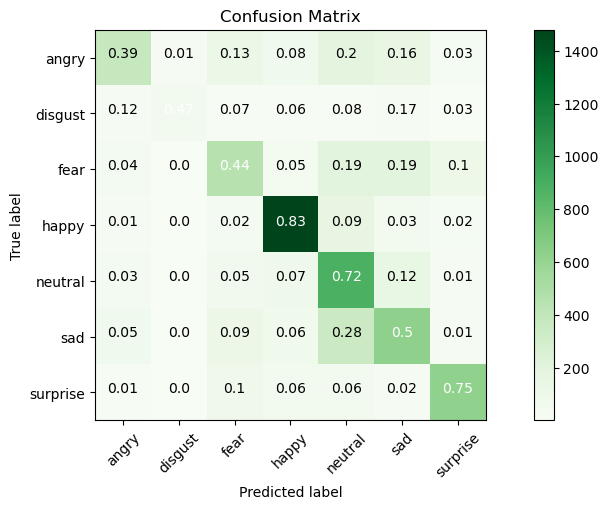

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_set.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(test_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=target_names))

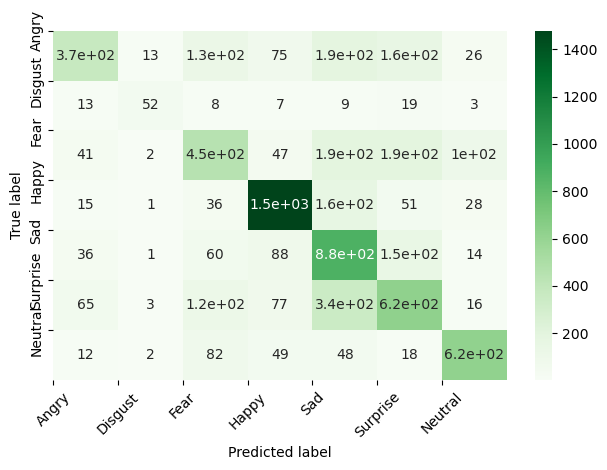

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_set.classes, y_pred)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#plt.imshow(cm, interpolation='nearest',cmap='Greens',annot='true')
sns.heatmap(cm,cmap='Greens',annot=True)
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Resnet Model Accuracy and loss

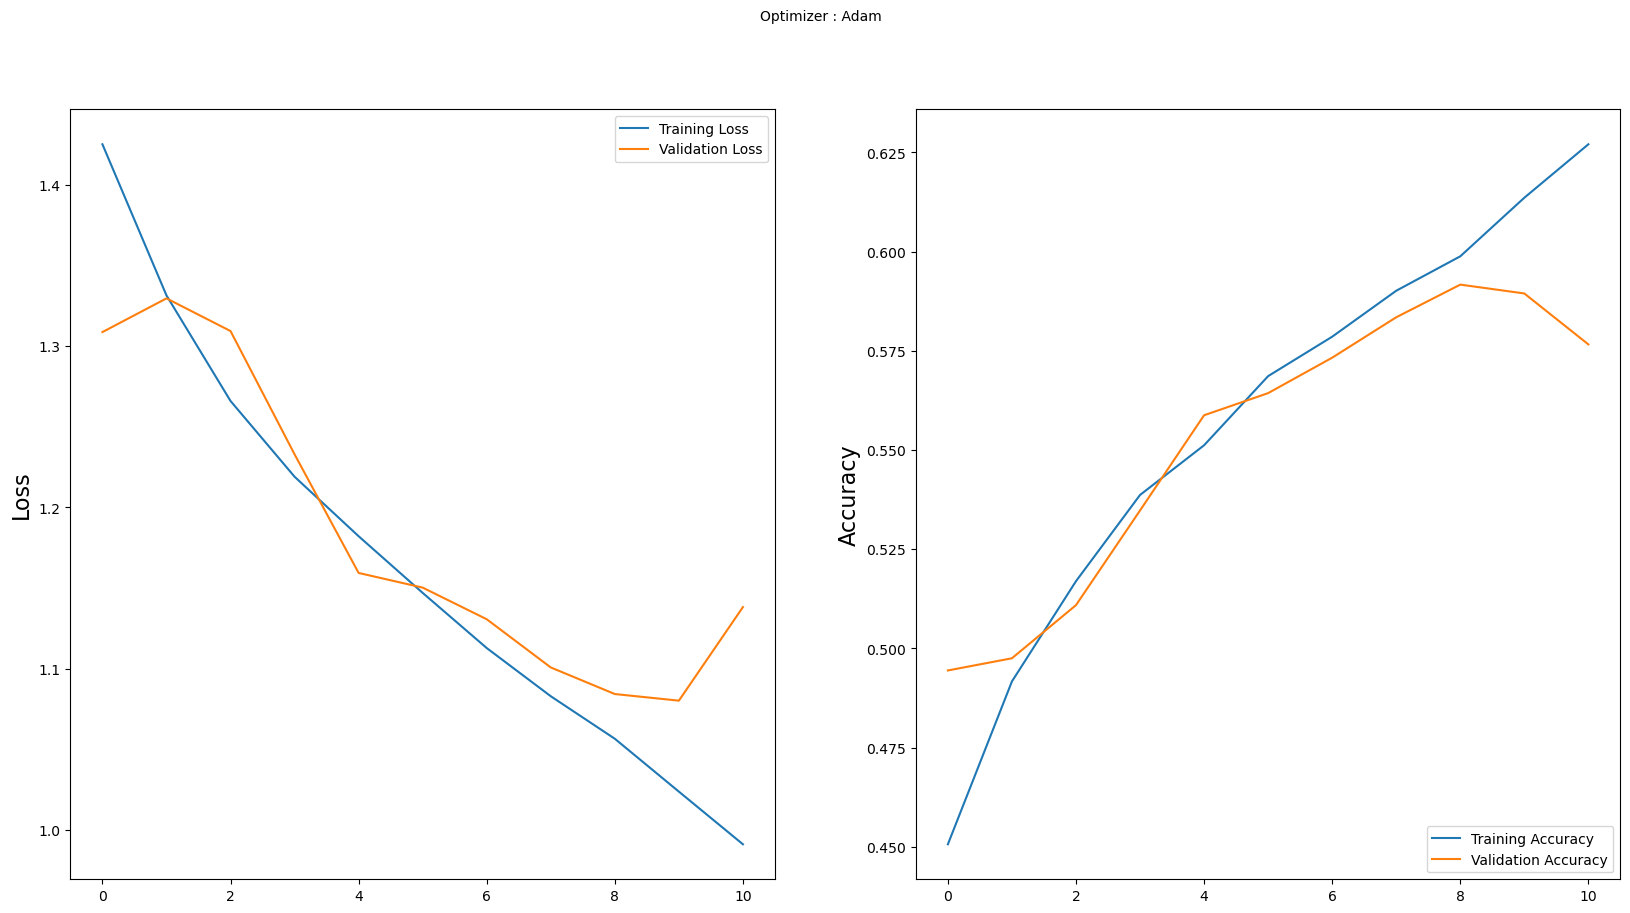

In [ ]:
# Resnet plot
# Resnet loss and accuracy
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(resnet_history.history['loss'], label='Training Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(resnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Conclusion
## 1. There are seven facial expression (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 7,178 examples.
## 2. The CNN model was chosen because it had the highest accuracy 73.40 perent and Resnet model's accuracy was around 63.
## 3. As a result, we save CNN model and use it to predict facial expressions.
## 4. Since, the emotion counts of disgust and surprise images are less therefore on local webcam it hardly detect those emotions.
## 5. Our model can successfully detect face and predict emotion on live feed as well as on Video.